In [2]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

In [3]:
### UTILITY FUNCTION FOR PLOTTING ###

def plot_history(ax, i, is_anomaly, window_len, color='blue', **pltargs):
    
    posrange = np.arange(0,i)
    
    ax.fill_between(posrange[window_len:], 
                    pltargs['low'][1:], pltargs['up'][1:], 
                    color=color, alpha=0.2)
    if is_anomaly:
        ax.scatter(i-1, pltargs['original'][-1], c='red')
    else:
        ax.scatter(i-1, pltargs['original'][-1], c='black')
    ax.scatter(i-1, pltargs['smooth'][-1], c=color)
    
    ax.plot(posrange, pltargs['original'][1:], '.k')
    ax.plot(posrange[window_len:], 
            pltargs['smooth'][1:], color=color, linewidth=3)
    
    if 'ano_id' in pltargs.keys():
        if pltargs['ano_id'].sum()>0:
            not_zeros = pltargs['ano_id'][pltargs['ano_id']!=0] -1
            ax.scatter(not_zeros, pltargs['original'][1:][not_zeros], 
                       c='red', alpha=1.)

# POINT ANOMALIES: RANDOM WALKS

In [4]:
### GENERATE DATA ###

np.random.seed(42)

n_series, timesteps = 3, 200

data = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                      process_noise=10, measure_noise=30)

data.shape

(3, 200)

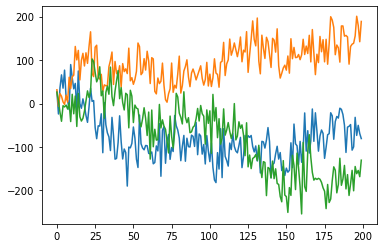

In [5]:
plt.plot(data.T)
np.set_printoptions(False)

In [6]:
### SLIDING WINDOW PARAMETER ###

window_len = 20

In [7]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,10))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])

    
print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation1.gif')
plt.close(fig)
print('DONE')

100%|██████████| 201/201 [00:05<00:00, 33.56it/s]


CREATING GIF...
DONE


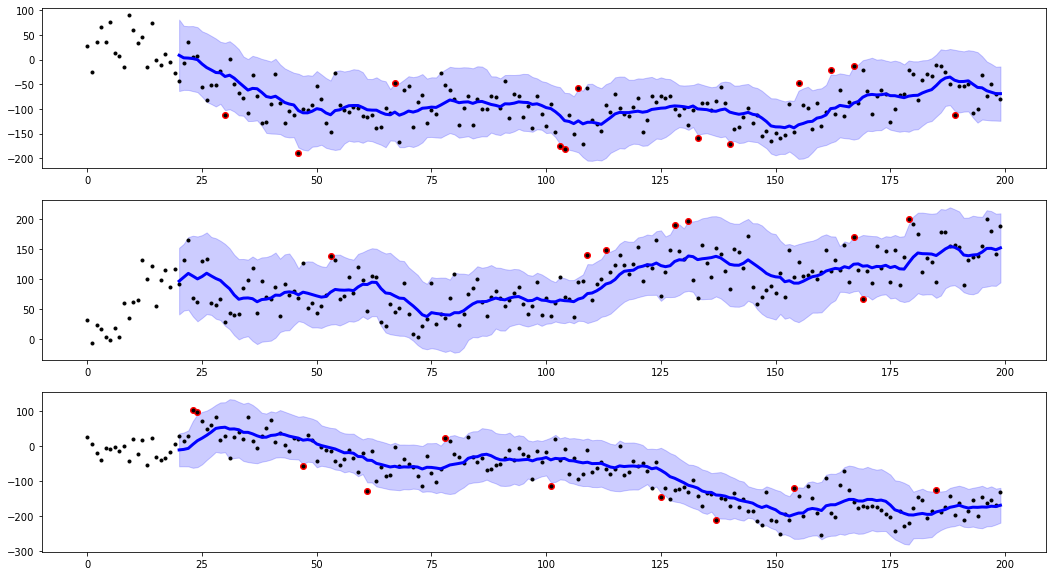

In [9]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

# POINT ANOMALIES: SEASONAL DATA WITHOUT TREND

In [10]:
### GENERATE DATA ###

np.random.seed(42)

n_series, timesteps = 3, 200

data = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                         freq=24, measure_noise=20, amp=[30,40,50])

data.shape

(3, 200)

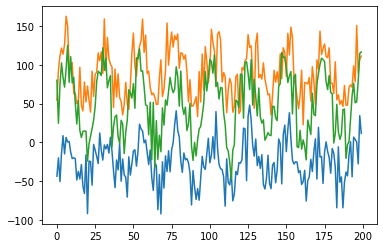

In [11]:
plt.plot(data.T)
np.set_printoptions(False)

In [10]:
### SLIDING WINDOW PARAMETER ###

window_len = 20

In [11]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,10))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = ExponentialSmoother(window_len=window_len//2, alpha=0.4)
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
    
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation2.gif')
plt.close(fig)
print('DONE')

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:07<00:00, 26.55it/s]
MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


CREATING GIF...
DONE


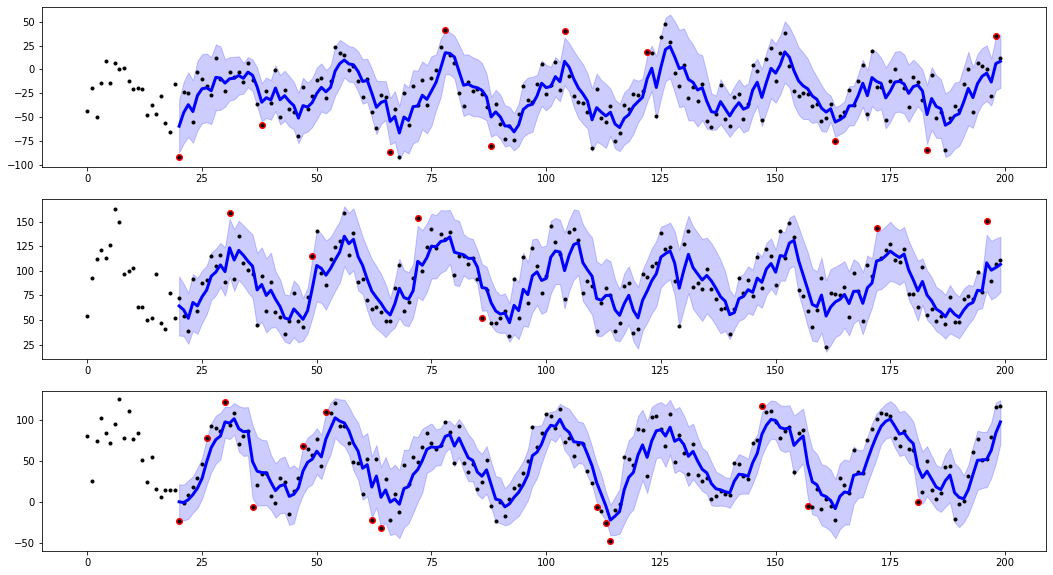

In [12]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

# PATTERN ANOMALIES: SEASONAL DATA WITH TREND

In [13]:
### GENERATE DATA ###

np.random.seed(42)

n_series, timesteps = 3, 600

data = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                      process_noise=1, measure_noise=0)
seasons = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                            freq=24, measure_noise=4, level=0, amp=10)
data = data + seasons

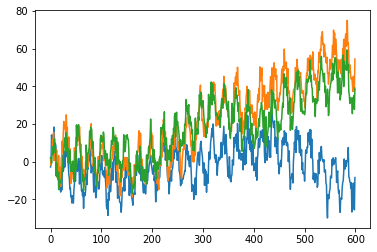

In [14]:
plt.plot(data.T)
np.set_printoptions(False)

In [15]:
### SLIDING WINDOW PARAMETER ###

window_len = 24*5

In [16]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,10))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                     window_len=window_len//3, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2.5)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation3.gif')
plt.close(fig)
print('DONE')

100%|████████████████████████████████████████████████████████████████████████████████| 601/601 [00:23<00:00, 26.00it/s]
MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


CREATING GIF...
DONE


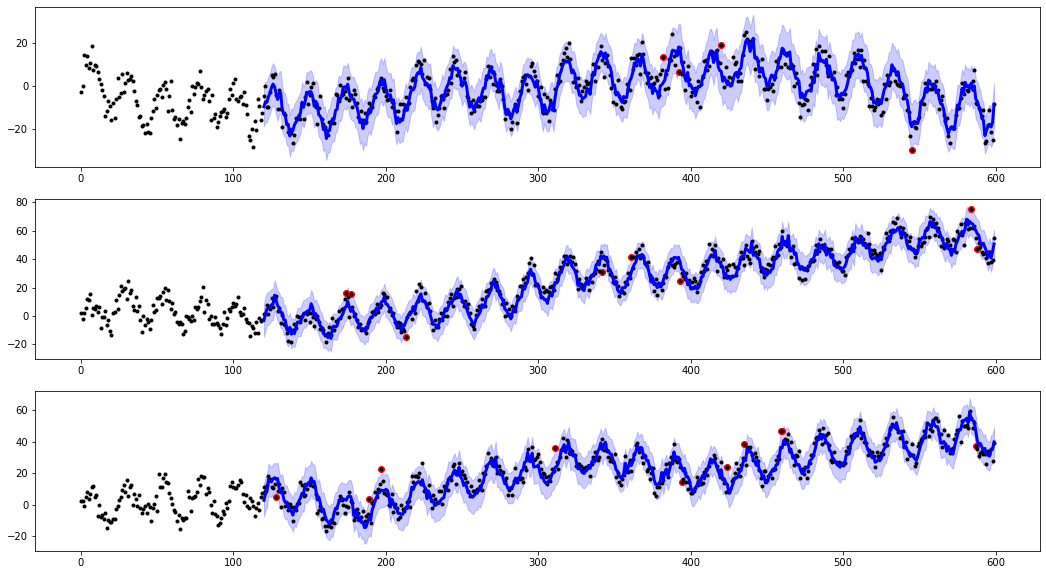

In [17]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

# PATTERN ANOMALIES: SEASONAL DATA WITH TREND AND SHIFT

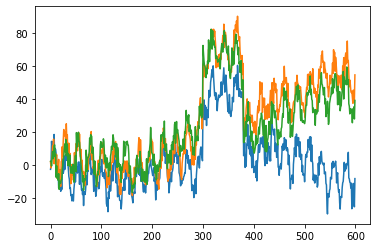

In [18]:
### GENERATE DATA ###

data[:,300:380] = data[:,300:380] + 40

plt.plot(data.T)
np.set_printoptions(False)

In [19]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,9))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
recovered = np.copy(data)

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                     window_len=window_len, window_type='ones')
        smoother.smooth(series['recovered'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=4)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            ano_series = np.where(is_anomaly)[0]
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            recovered[ano_series,i] = smoother.smooth_data[ano_series,[-1]]
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    series['recovered'] = np.hstack([series['recovered'], recovered[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation4.gif')
plt.close(fig)
print('DONE')

100%|████████████████████████████████████████████████████████████████████████████████| 601/601 [00:22<00:00, 26.89it/s]
MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


CREATING GIF...
DONE


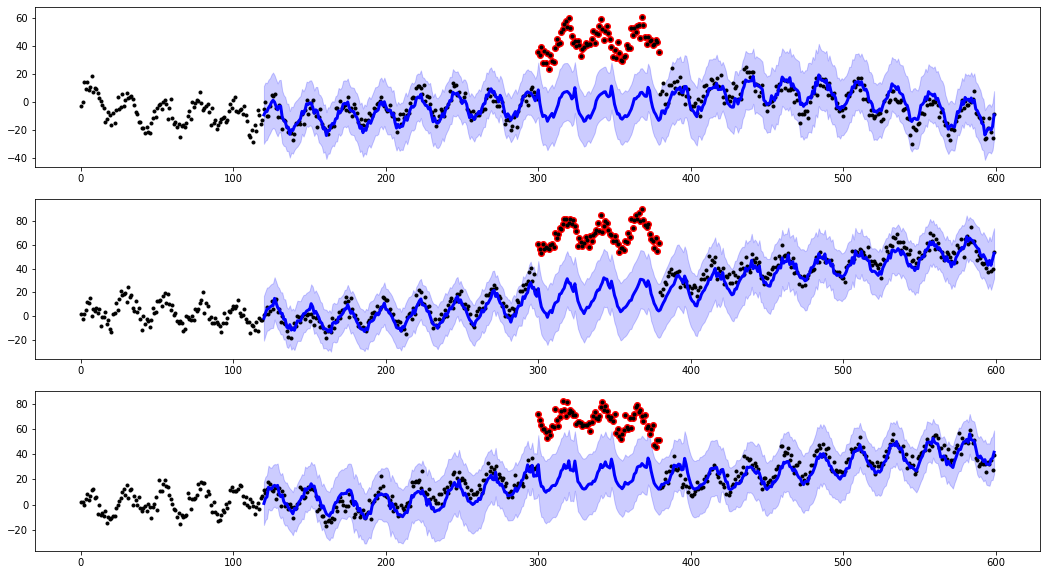

In [20]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)